# Scraping League of Legends Player Stats

This project uses python to scrape data from na.op.gg. It collects data from a list of players of the computer game League of Legends in order to provide some visual representations of the data.

In [1]:
# Standard libraries to use for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
%matplotlib inline

# Libraries to open URLs and extract data from HTML
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re



## Scrape page to collect list of popular players

We need to scrape the first webpage to collect a list of 385 players. These are professional players or streamers of the game.

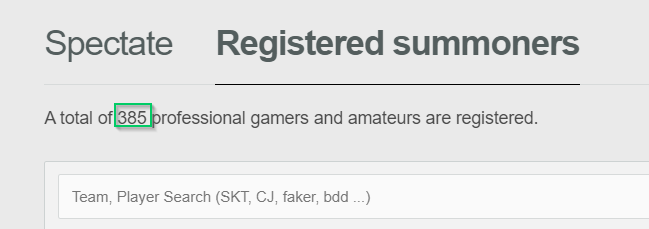

In [3]:

# URL to grab list of summoner names (player names)
url = "https://na.op.gg/spectate/list/"
html = urlopen(url)
soup = BeautifulSoup(html,'lxml')

# Get title of page
title = soup.title.text
print(title)

# Create a list to contain the summoner names
SummonerList = []

# Populate list of professional gamers and streamers
for SummonerName in soup.find_all("div", class_="SummonerName"):
    SummonerList.append(SummonerName.text)

# Print a sample of list
print(SummonerList[:50])

# Print total number of summoner names captured, 385, perfect!
print(len(SummonerList))


List of Professional Gamers - League of Legends
['bigfatlp', 'Dyrus', 'ReginaId', 'Cart Waddle Dee', 'BillyBoss1', 'DontMashMe', 'Radiance Hai', 'GIRL STREAMER', 'Xpecial', 'RushFrog', 'bolls', 'Wingsofdeathx', 'Crab Battle', 'Dr Quas', 'Slooshi1', 'D9mvWHddJO', 'Patoy', 'InnoX', 'Much Fuun', 'Bischu', 'CaliTrlolz8', 'Link', 'rtbf21944884', 'tempname5648', 'Fasca', 'Boyfriend', 'mengxiang', 'Åzingy', 'Shout', 'Billy Yu', 'FerohHD onTwitch', 'hammi', 'hamacho', 'TranceTherapy1', 'z2Fkg03qao', 'Ohq', 'DECAYED SHREK', 'ChumpJohn', 'OZddZGuwph', 'ChumpJohnsVlad', 'RF Legendary', 'PARKJONGWON', 'heal shield BOT', 'Lilballz', 'SEN Kez', 'Falcon God', 'TTV Fiku', 'itsathrow', 'OMG Cloud', 'D D A B O N G']
385


In [25]:
from time import sleep
from random import randint


# Create empty DataFrame to be populated later
data = pd.DataFrame()

inactive_players = []

# Loop through players and populate DataFrame
for SummonerName in SummonerList:
    
    #Setup URL for player, ensuring to URL encode the name, and open URL
    url = "https://na.op.gg/summoner/userName=" + urllib.parse.quote(SummonerName)
    html = urlopen(url)
    soup = BeautifulSoup(html,'lxml')
    
    # If a player has not played ranked this season, do not add them to our DataFrame
    if soup.find('div', class_ = "TierRank unranked"):
        inactive_players.append(SummonerName)
        continue
    
    # Grab stats from HTML
    winrate = soup.find("span", {"class": "winratio"}).text.strip()
    wins = soup.find("span", {"class": "wins"}).text.strip()
    losses = soup.find("span", {"class": "losses"}).text.strip()
    rank = soup.find('div', class_ = 'TierRank').text.strip()
    league_points = soup.find("span", {"class": "LeaguePoints"}).text.strip()
    ladder_rank = soup.find("span", {"class": "ranking"}).text.strip()
                                 
    
    # Append data to dataframe
    data = data.append({'SummonerName' : SummonerName,
                        'Rank' : rank,
                        'League Points': league_points,
                        'Wins' : wins,
                        'Losses' : losses,
                        'Winrate': winrate},
                         ignore_index=True)
    
    # Implement random sleep timer between 1-4 seconds to prevent high traffic on server 
    sleep(randint(1,3))
    #sleep(2,4)
    
    # Output data to csv file so we don't have to scrape the site again
    data.to_csv("Data.csv", index=False)

print(str(len(inactive_players)) + " Inactive Players")    
print(data.head())




224 Inactive Players
  League Points Losses        Rank  SummonerName        Winrate  Wins
0         16 LP   453L      Master      bigfatlp  Win Ratio 50%  453W
1         75 LP     8L  Platinum 1         Dyrus  Win Ratio 53%    9W
2         65 LP   191L  Platinum 1      ReginaId  Win Ratio 53%  212W
3        100 LP    18L  Platinum 1    BillyBoss1  Win Ratio 61%   28W
4         48 LP   110L   Diamond 4  Radiance Hai  Win Ratio 48%  103W


## Data Cleaning

In this step we will work to clean the data up to prepare for visualizations.

In [8]:
# Read the csv that was saved from previous step
df = pd.read_csv("Data.csv")

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# Show the number of rows, columns
print(df.shape)

# Show the first 5 records
# We have 161 records (players) and 6 columns
df.head()

(161, 6)


,League Points,Losses,Rank,SummonerName,Winrate,Wins
0,1 LP,453L,Master,bigfatlp,Win Ratio 50%,452W
1,75 LP,8L,Platinum 1,Dyrus,Win Ratio 53%,9W
2,65 LP,191L,Platinum 1,ReginaId,Win Ratio 53%,212W
3,100 LP,18L,Platinum 1,BillyBoss1,Win Ratio 61%,28W
4,48 LP,110L,Diamond 4,Radiance Hai,Win Ratio 48%,103W


In [9]:
# Remove non-numerical data from fields using regex
df['League Points'] = df['League Points'].str.replace(r"[a-zA-Z,]", '', regex=True).astype(int)
df['Losses'] = df['Losses'].str.replace(r'[a-zA-Z]', '', regex=True).astype(int)
df['Wins'] = df['Wins'].str.replace(r'[a-zA-Z]', '', regex=True).astype(int)
df['Winrate'] = df['Winrate'].str.replace(r'[a-zA-Z%]', '', regex=True).astype(int)

# Split Rank field into Tier and Division fields
df[['Tier','Division']] = df['Rank'].str.split(expand=True)

# Create total games played field
df['Games Played'] = df['Losses'] + df['Wins']

# Re-arrange order of columns for clarity
df = df[['SummonerName', 'Rank', 'Tier', 'Division', 'League Points', 'Games Played', 'Wins', 'Losses', 'Winrate']]

# Lets make a more accurate winrate rounded to 2 decimals using Wins and Games Played
df['Winrate'] = round((df['Wins']/df['Games Played']) * 100,2)

print(df.head())

   SummonerName        Rank      Tier Division  League Points  Games Played  \
0      bigfatlp      Master    Master     None              1           905   
1         Dyrus  Platinum 1  Platinum        1             75            17   
2      ReginaId  Platinum 1  Platinum        1             65           403   
3    BillyBoss1  Platinum 1  Platinum        1            100            46   
4  Radiance Hai   Diamond 4   Diamond        4             48           213   

   Wins  Losses  Winrate  
0   452     453    49.94  
1     9       8    52.94  
2   212     191    52.61  
3    28      18    60.87  
4   103     110    48.36  


## Display Distribution of Player Rank

Master         11
Grandmaster    17
Challenger     27
Diamond        32
Platinum       74
Name: Tier, dtype: int64


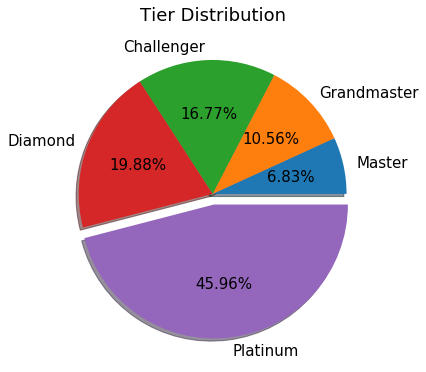

In [10]:
# Pie plot showing ranked distribution percentage
# Create font size and pie chart size, and explode one slice
plt.rcParams['font.size'] = 15
plt.rcParams["figure.figsize"] = (6,14)
explode = (0, 0, 0, 0, 0.08)

# Grab each Tier and the count of players in each
# Sort based on ascending, so we always explode the biggest slice
data = df['Tier'].value_counts().sort_values(ascending=True)

print(data.head())

# Create pie plot
data.plot.pie(autopct="%.2f%%", shadow=True, label="", explode=explode, title="Tier Distribution")


## Display Top 15 Ranked Players

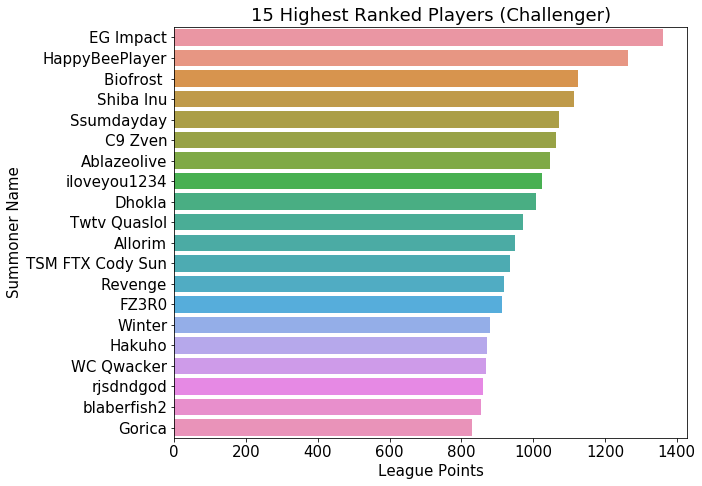

In [11]:
# The order of ranked tiers in the game, with Challenger being the highest
tier_Order = ['Challenger', 'Grandmaster', 'Master', 'Diamond', 'Platinum']


# Sort data by ranked tiers based from highest ranked tier to lowest ranked tier
# For example, Diamond 1 is a higher rank than Diamond 2
df['Tier'] = pd.Categorical(df['Tier'], tier_Order)
df_sorted_ranks = df.sort_values(["Tier", "Division", "League Points"], ascending=[1, 1, 0])

# Graph 20 highest ranked players
df_sorted_ranks_20 = df_sorted_ranks.head(20)


# Since they are all ranked in Challenger and have League Points, we can use this for the X-axis
plt.figure(figsize=(10,7))
ax = sns.barplot(x="League Points", y="SummonerName", data=df_sorted_ranks_20)
ax.set_title("15 Highest Ranked Players (Challenger)", fontsize=18)
ax.set_xlabel("League Points", fontsize=15)
ax.set_ylabel("Summoner Name", fontsize=15)
plt.tight_layout()
plt.show()

# We can see the top 3 players are a good distance ahead compared to others


## Display Wins and Losses of Top 10 Players

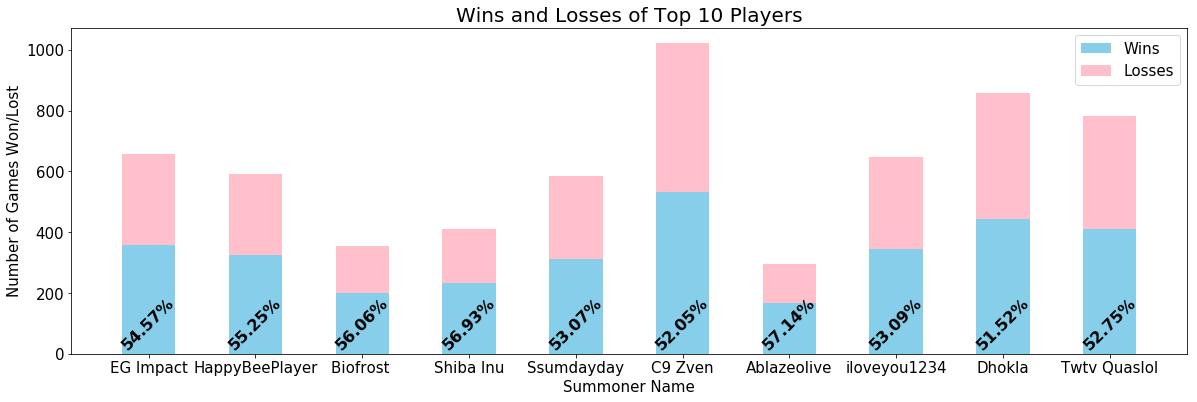

In [17]:
# Get highest number of games played, top 10 players

# Get top 10 players
df_sorted_ranks_10 = df_sorted_ranks_20.head(10)

labels = df_sorted_ranks_10['SummonerName']
wins = df_sorted_ranks_10['Wins']
losses = df_sorted_ranks_10['Losses']
width = .5

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(6)

ax1 = ax.bar(labels, wins, width, label='Wins', color='skyblue')
ax2 = ax.bar(labels, losses, width, label='Losses', bottom=wins, color='pink')

ax.set_ylabel('Number of Games Won/Lost', fontsize=15)
ax.set_xlabel('Summoner Name', fontsize=15)
ax.set_title('Wins and Losses of Top 10 Players', fontsize=20)
ax.legend()

for wins, losses in zip(ax1, ax2):
    h1 = wins.get_height()
    h2 = losses.get_height()
    winrate_text = (h1 / (h1+h2)) *100
    plt.text(wins.get_x() + wins.get_width() / 2., 100, "%.2f%%" % winrate_text, ha="center", va="center", color="black", fontsize=16, fontweight="bold", rotation=45)


plt.show()





## -- Testing --

In [13]:
#Testing grabbing prior season data

SummonerName = 'Doublelift'
url = "https://na.op.gg/summoner/userName=" + urllib.parse.quote(SummonerName)
html = urlopen(url)
soup = BeautifulSoup(html,'lxml')


past_season_ranks = soup.find('ul', class_ = 'PastRankList').text.strip()
ladder_rank = soup.find("span", {"class": "ranking"}).text.strip()
#print(past_season_ranks)
# Split season and ranked tier with space
split = past_season_ranks.split()
for season in split:
    print(season)
# 0 and even numbers are Season
# 1 and odd numbers are Tier

#print(split[0])
#print(split[1])
#print(split[3])
#print(ladder_rank)

S4
Challenger
S5
Diamond
S6
Master
S7
Master
S8
Master
S9
Diamond
S2020
Diamond
